# Modele Seq2Seq i atencja
Poniższy notebook jest inspirowany tym tutorialem PyTorcha: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html. Zachęcam żeby zajrzeć tam po więcej informacji.

W tym notebooku będziemy próbować rozwiązać problem automatycznego tłumaczenia zdań z jednego języka naturalnego na drugi -- konkretniej z języka polskiego na angielski. Dla przykładu model otrzymujący zdanie:

> Myślę, że mnie okłamałeś

Powinien zwrócić zdanie
> I think you lied to me.



# Importy i przygotowanie danych
Poniżej znajdują się importy bibliotek potrzebnych do rozwiązania problemu a także skrypt do ładowania zbioru danych zawierającego pary zdań w języku polskim i angielskim. Poniższy kod można odpalić i schować, ale zachęcamy do zaznajomienia się z tym jak wygląda obróbka danych.


In [ ]:
%matplotlib inline

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import unicodedata
import string
import numpy as np
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
!wget https://raw.githubusercontent.com/gmum/ml2020-21/master/lab/resources/pol.txt

--2021-01-17 12:54:16--  https://raw.githubusercontent.com/gmum/ml2020-21/master/lab/resources/pol.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5865362 (5.6M) [text/plain]
Saving to: ‘pol.txt.3’

pol.txt.3           100%[===================>]   5.59M  --.-KB/s    in 0.06s   

2021-01-17 12:54:16 (91.9 MB/s) - ‘pol.txt.3’ saved [5865362/5865362]



Poniżej przygotowujemy klasę `Lang` która będzie służyła jako struktura do obsługiwania naszego języka (osobna dla angielskiego i polskiego w naszym przypadku). Do każdego słowa w języku przypisujemy indeks (liczbę porządkową identyfikującą słowo). Dodatkowo definiujemy trzy dodatkowe indeksy:

* 0 dla początku zdania (Start of Sentence, SOS)
* 1 dla końca zdania (End of Sentence, EOS)
* 2 dla paddingu ("pustych" wartości). Wartościami tymi będziemy wypełniać zdania w batchu tak, żeby wszystkie były równej długości -- dzięki temu łatwiej będzie zrównoleglić przetwarzanie ich na GPU.

In [ ]:


SOS_token = 0
EOS_token = 1
PAD_token = 2

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS", 2: "PAD"}
        self.n_words = 3 # Count SOS, EOS and PAD

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

Funkcje do normalizowania wchodzących zdań - zamieniamy Unicode na ASCII, zamieniamy wszystkie wielkie litery na małe itd.

In [ ]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = s.replace("ł", "l")
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open(f'{lang1}.txt', encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')[:2]] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Wyrzućmy zdania które są zbyt długie (ponad 20 słów).

In [ ]:
MAX_LENGTH = 20

def filterPair(p):
    return len(p[0].split(' ')) <= MAX_LENGTH and \
        len(p[1].split(' ')) <= MAX_LENGTH


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

Pełny proces przetwarzania danych wygląda następująco:

- Wczytujemy plik z danymi, dzielimy go na pary zdań.
- Normalizujemy tekst
- Zamieniamy zdania w listy słów.




In [ ]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print(pairs[0])
    print(f"Read {len(pairs)} sentence pairs")
    pairs = filterPairs(pairs)
    print(f"Trimmed to {len(pairs)} sentence pairs")
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('pol', 'eng', True)
print("Przykładowe pary zdań:")
for _ in range(3):
    print(random.choice(pairs))

Reading lines...
['idz .', 'go .']
Read 40389 sentence pairs
Trimmed to 40289 sentence pairs
Counting words...
Counted words:
eng 20475
pol 8084
Przykładowe pary zdań:
['tom ma duza rodzine .', 'tom has a big family .']
['wyjdz z podniesionymi rekami .', 'come out with your hands up .']
['niczego w ogole nie widzialem .', 'i didn t see anything at all .']


Na koniec definiujemy jeszcze funkcje, które pozwolą nam zamienić zdania w tensory, które nasza sieć będzie w stanie zrozumieć.

In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)


def pad_sequences(data_batch):
    pl_batch, en_batch = [], []
    for pl_sentence, en_sentence in data_batch:
        pl_batch += [pl_sentence]
        en_batch += [en_sentence]
    pl_batch = pad_sequence(pl_batch, padding_value=PAD_token, batch_first=True)
    en_batch = pad_sequence(en_batch, padding_value=PAD_token, batch_first=True)
    return pl_batch, en_batch

def prepare_dataset(batch_size):
    rng = np.random.RandomState(567)
    indices = np.arange(len(pairs))
    rng.shuffle(indices)
    train_indices = indices[:int(len(pairs) * 0.8)]
    test_indices = indices[int(len(pairs) * 0.8):]
    train_pairs = list(pairs[idx] for idx in train_indices)
    test_pairs = list(pairs[idx] for idx in test_indices)
    tensor_train_pairs = [tensorsFromPair(pairs[idx]) for idx in train_indices]
    tensor_test_pairs = [tensorsFromPair(pairs[idx]) for idx in test_indices]

    train_loader = DataLoader(tensor_train_pairs, batch_size=batch_size,
                            shuffle=True, collate_fn=pad_sequences)
    test_loader = DataLoader(tensor_test_pairs, batch_size=batch_size,
                            shuffle=True, collate_fn=pad_sequences)
    return train_pairs, test_pairs, train_loader, test_loader

# Model Seq2Seq



W tym celu wykorzystany rekurencyjne sieci neuronowe (RNN-y), które poznaliśmy na poprzednich zajęciach. Konkretniej zbudujemy za ich pomocą model Sequence to Sequence (Seq2Seq), w której wykorzystamy dwie sieci rekurencyjne:
1. Enkoder, który będzie przyjmował kolejno słowa ze zdania wejściowego i kompresował informacje o nich w swoim stanie ukrytym.
2. Dekoder, który będzie generował kolejne słowa w języku docelowym. 

![seq2seq](https://docs.chainer.org/en/stable/_images/seq2seq.png)
Źródło: https://docs.chainer.org/

## Funkcje pomocnicze i ewaluacyjne

In [ ]:
def predict(encoder, decoder, inputs, targets=None, max_len=MAX_LENGTH):
    batch_size = inputs.size(0)

    encoder_outputs, encoder_hidden = encoder(inputs)

    decoder_input = torch.tensor([[SOS_token]] * batch_size, device=device)
    decoder_hidden = encoder_hidden
    decoder_output, decoder_attention = decoder(
        decoder_input,
        decoder_hidden,
        targets=targets,
        max_len=max_len,
        encoder_outputs=encoder_outputs)
    return decoder_output, decoder_attention

def translate(encoder, decoder, sentence):
    inputs = tensorFromSentence(input_lang, sentence).unsqueeze(0).cuda()
    decoder_output, decoder_attention = predict(encoder, decoder, inputs)

    decoded_words = []
    for word in decoder_output[0]:
        top_word = word.argmax(-1).item()
        decoded_words.append(output_lang.index2word[top_word])
        if top_word == EOS_token:
            break

    if decoder_attention is not None:
        # [out_words, in_words]
        att = decoder_attention.cpu().detach().numpy()
        att = att[0, :len(decoded_words), :]
        fig, ax = plt.subplots()

        ax.imshow(att)
        ax.set_xticklabels([''] + sentence.split(' ') +
                        ['EOS'], rotation=90)
        ax.set_yticklabels([''] + decoded_words)


        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

        plt.show()

    return decoded_words
        
def translate_randomly(encoder, decoder, pairs, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = translate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

## Pętla trenująca

In [ ]:
def train(encoder, decoder, lr=0.01, batch_size=256, teacher_forcing_ratio=0.5, epochs_num=100):

    # Prepare dataset, loss functions, optimizer
    train_pairs, test_pairs, train_loader, test_loader = prepare_dataset(batch_size)

    criterion = nn.CrossEntropyLoss(ignore_index=PAD_token)

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=lr)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=lr)

    encoder.cuda()
    decoder.cuda()

    for epoch in range(epochs_num + 1):

        # Training
        epoch_train_loss = 0.
        for in_batch, out_batch in train_loader:
            in_batch, out_batch = in_batch.cuda(), out_batch.cuda()

            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()
        
            teacher_inputs = out_batch if random.random() < teacher_forcing_ratio else None
        
            decoder_output, decoded_attention = predict(
                encoder, decoder, in_batch,
                targets=teacher_inputs,
                max_len=out_batch.size(1)
            )
        
            loss = criterion(decoder_output.transpose(1, 2), out_batch)
            loss.backward()
        
            encoder_optimizer.step()
            decoder_optimizer.step()

            epoch_train_loss += loss.item()

        # Evaluation
        if epoch % 25 == 0:
            with torch.no_grad():
                print("=" * 25, "Translation test", "=" * 25)
                translate_randomly(encoder, decoder, test_pairs, n=5)

        mean_train_loss = epoch_train_loss / len(train_loader)
        print(f"Epoch: {epoch}. Train loss: {mean_train_loss}")

# Zadanie 1 - Dekoder w Seq2Seq (4 pkt.)

W tym zadaniu należy zaimplementować dekoder z modelu Seq2Seq. Kod enkodera jest dostępny poniżej i ma Państwu ułatwić odpowiednie zaimplementowanie dekodera.


Dekoder otrzymuje na wejściu następujące argumenty:
- `input` - tensor o wymiarach `[batch_size, seq_len]` zawierający indeksy kolejnych słów. Zdania w batchu zawsze mają równą długość `seq_len` (do krótszych zdań dodaliśmy padding).
- `hidden` - ostatnia reprezentacja ukryta z enkodera .
- `targets` - `None` albo `torch.tensor` o wymiarach `[batch_size, seq_len]` zawierający indeksy słów w języku docelowym. Jeżeli jest podany to należy zaimplementować teacher forcing na jego podstawie.
- `max_len` - Długość sekwencji, którą mamy zwrócić.
- `encoder_outputs` - w tym zadaniu ten argument należy zignorować, przyda się dopiero w kolejnym zadaniu.

Dekoder ma zwrócić dwie zmienne:
- `output` - tensor o wymiarach `[batch_size, seq_len, vocab_size]` reprezentujące logity, które po zaaplikowaniu softmaksa (co będzie zrobione już poza dekoderem) będą reprezentowały prawdopodobieństwa słów przewidzianych przez nasz dekoder.
- `attention_weights` - w tym zadaniu należy zawsze zwracać `None`.


**HINT 1**: Warto pamiętać o argumencie `batch_first=True` przy definiowaniu RNN-a.

**HINT 2**: W enkoderze mogliśmy użyć jednego wywołania klasy LSTM, jako że od razu mieliśmy wszystkie wejścia (słowa języka wejściowego). W przypadku dekodera nie jest to możliwe, jako że wejściem w kroku `t+1` jest wyjście z kroku `t`. Oznacza to że prawdopodobnie potrzebna będzie pętla `for`.

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, batch_first=True)

    def forward(self, input):
        embedded = self.embedding(input)
        output, hidden = self.lstm(embedded)
        return output, hidden

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(DecoderRNN, self).__init__()
        ???

    def forward(self, input, hidden, targets=None, max_len=None, encoder_outputs=None):
        ???
        return output, None

In [ ]:
hidden_size = 128
embedding_size = 256
encoder = EncoderRNN(input_lang.n_words, embedding_size, hidden_size).to(device)
decoder = DecoderRNN(output_lang.n_words, embedding_size, hidden_size).to(device)

train(encoder, decoder, lr=0.005, epochs_num=100)

========================= Translation test =========================
> mozemy zrobic to innym razem ?
= can we do it another time ?
< i is a . EOS

> wydaje mi sie ze go znam .
= i think i know him .
< i is a to . EOS

> tom powiedzial mi ze lubi plywac .
= tom told me that he likes to swim .
< i is a to to . EOS

> lubie maslo bardziej niz ser .
= i like butter better than cheese .
< i is a to to . EOS

> zlodziej wlamal sie do domu gdy nas nie bylo .
= a thief broke into the house while we were away .
< i is a to to the . EOS

Epoch: 0. Train loss: 5.0525786271170965
Epoch: 1. Train loss: 4.270484547766428
Epoch: 2. Train loss: 4.041841128515819
Epoch: 3. Train loss: 3.84948664430588
Epoch: 4. Train loss: 3.4589100867982894
Epoch: 5. Train loss: 3.4652734957044085
Epoch: 6. Train loss: 3.244848096181476
Epoch: 7. Train loss: 3.1803611857550487
Epoch: 8. Train loss: 3.1516595435520958
Epoch: 9. Train loss: 2.997663145973569
Epoch: 10. Train loss: 2.9174035371295988
Epoch: 11. Train lo

# Zadanie 2 - Atencja w RNN-ach (3 pkt.)

![seq2seq z dekoderem](https://www.researchgate.net/profile/Chandan_Reddy6/publication/329464533/figure/fig3/AS:701043021197314@1544153089772/An-attention-based-seq2seq-model.ppm)

Źródło: https://github.com/google/seq2seq

W tym zadaniu należy napisać kod nowego dekodera, który ma działać podobnie jak dekoder w poprzednim zadaniu, ale jednocześnie ma wykorzystywać mechanizm atencji.

W normalnym dekoderze, w kroku `t` wejściem do komórki LSTM-a (pomijamy tutaj przekazywanie stanu ukrytego) była wyłącznie zembeddowana reprezentacja $\bar{y}_t$. W dekoderze z atencją na wejściu podawna będzie konkatenacja tego wektora oraz specjalnego wektora $z_t$ stworzonego na podstawie wyjść z enkodera: $\tilde{h}_t = [\bar{y}_t, z_t]$. 

Wektor $z_t$ jest pozyskiwany za pomocą mechanizmu atencji. Intuicyjnie chcielibyśmy w nim zebrać informacje z enkodera, które będą najistotniejsze przy dekodowaniu aktualnego słowa. Przyjmijmy, że mamy funkcję alignmentu $a(h, e)$, która jest nam w stanie powiedzieć jak bardzo podobne do siebie są stan ukryty dekodera $h$ oraz reprezentacja słowa $e$.

Wtedy 

$$
\begin{align}
w_i &= \frac{ \exp(a(h, e_i)) }{\sum_{j} \exp(a(h, e_j))} \\
z_t &= \sum_i e_i \cdot w_i
\end{align}
$$


W naszym wypadku funkcja alignmentu $a(h, e)$ ma być siecią neuronową z dwoma warstwami o kolejnych wymiarach: `[embedding_size + hidden_size, hidden_size, 1]` i aktywacją tanh po pierwszej warstwie.

Argumenty wejściowe i wyjściowe z dekodera są takie same jak w poprzednim z zadaniu z wyjątkiem:
- Tym razem na wejściu otrzymujemy tensor `encoder_outputs` o wymiarach `[batch_size, encoder_seq_len, hidden_size]`. To są reprezentacje $e_i$, które należy wykorzystać w mechanizmie atencji.
- Tym razem na wyjściu `attention_weights` powinno być tensorem o wymiarach `[batch_size, decoder_seq_len, encoder_seq_len]` zawierającym wagi $w_i$. **HINT:** wartości tego tensora powinny się sumować do jedynki na ostatnim wymiarze.

In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(AttnDecoderRNN, self).__init__()
        ???

    def forward(self, input, hidden, targets=None, max_len=None, encoder_outputs=None):
        ???
        return output, seq_att_weights

========================= Translation test =========================
> ile kosztowaly te okulary przeciwsloneczne ?
= how much did these sunglasses cost ?


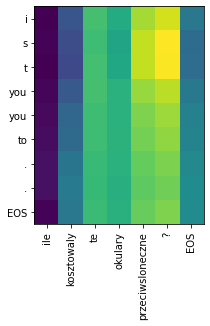

< i s t you you to . . EOS

> miales okazje porozmawiac z tomem ?
= did you have a chance to talk to tom ?


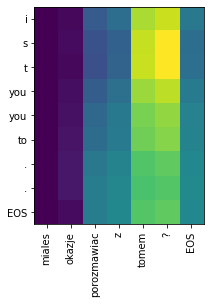

< i s t you you to . . EOS

> tom nie wspomnial kogo spotkal .
= tom didn t mention who he d met .


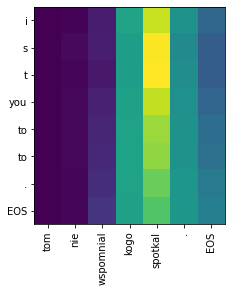

< i s t you to to . EOS

> mozemy na ciebie liczyc ?
= can we count on you ?


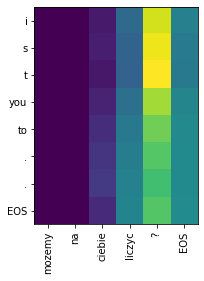

< i s t you to . . EOS

> mysle ze nie powinnismy ufac tomowi .
= i don t think we should trust tom .


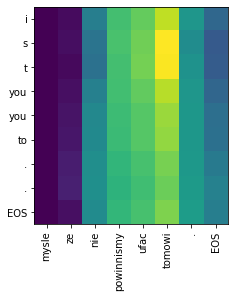

< i s t you you to . . EOS

Epoch: 0. Train loss: 5.129127396477593
Epoch: 1. Train loss: 4.417040122879876
Epoch: 2. Train loss: 4.067995224680219
Epoch: 3. Train loss: 3.740036618141901
Epoch: 4. Train loss: 3.371396651343694
Epoch: 5. Train loss: 3.0900035509987482
Epoch: 6. Train loss: 2.9499138234153626
Epoch: 7. Train loss: 2.697976583526248
Epoch: 8. Train loss: 2.490465729955643
Epoch: 9. Train loss: 2.239030700827402
Epoch: 10. Train loss: 2.0691995469350664
Epoch: 11. Train loss: 1.9558707286441137
Epoch: 12. Train loss: 1.759294042511592
Epoch: 13. Train loss: 1.6562249537498233
Epoch: 14. Train loss: 1.5519587605718583
Epoch: 15. Train loss: 1.392688279587125
Epoch: 16. Train loss: 1.29055997823912
Epoch: 17. Train loss: 1.2594804281280154
Epoch: 18. Train loss: 1.1016963043856243
Epoch: 19. Train loss: 1.028177346028979
Epoch: 20. Train loss: 0.9811902954464867
Epoch: 21. Train loss: 0.9344692864115276
Epoch: 22. Train loss: 0.8894587939693814
Epoch: 23. Train loss: 0.8317

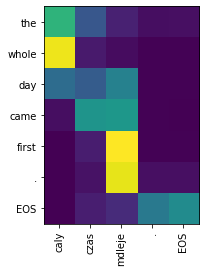

< the whole day came first . EOS

> tom bardzo teskni za mary .
= tom misses mary a lot .


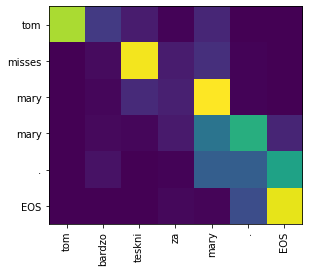

< tom misses mary mary . EOS

> banany sa zolte .
= bananas are yellow .


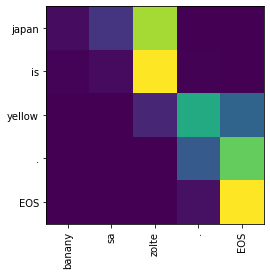

< japan is yellow . EOS

> ile wydales na ostatnie wakacje ?
= how much money did you spend on your last holiday ?


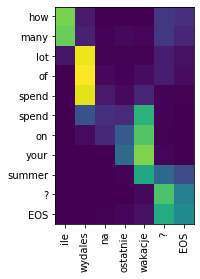

< how many lot of spend spend on your summer ? EOS

> powiedz nam wiecej .
= tell us more .


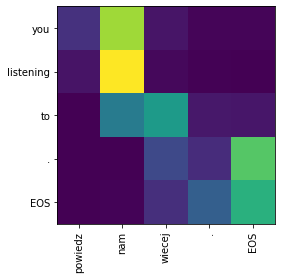

< you listening to . EOS

Epoch: 25. Train loss: 0.7960740959360486
Epoch: 26. Train loss: 0.7366204600012491
Epoch: 27. Train loss: 0.6945200295202316
Epoch: 28. Train loss: 0.6270041584022461
Epoch: 29. Train loss: 0.6332342877747521
Epoch: 30. Train loss: 0.5983022836938737
Epoch: 31. Train loss: 0.6263116371063959
Epoch: 32. Train loss: 0.610757610627583
Epoch: 33. Train loss: 0.4948881928409849
Epoch: 34. Train loss: 0.5170875603244418
Epoch: 35. Train loss: 0.5207000001082345
Epoch: 36. Train loss: 0.49370619418129086
Epoch: 37. Train loss: 0.4657332802575732
Epoch: 38. Train loss: 0.46608302872332313
Epoch: 39. Train loss: 0.46086727780482123
Epoch: 40. Train loss: 0.44414703737175654
Epoch: 41. Train loss: 0.4218870464061934
Epoch: 42. Train loss: 0.37898973659390495
Epoch: 43. Train loss: 0.3888667806509941
Epoch: 44. Train loss: 0.38294102913803524
Epoch: 45. Train loss: 0.3980348799673338
Epoch: 46. Train loss: 0.4012356386298225
Epoch: 47. Train loss: 0.3681437668819276
Epo

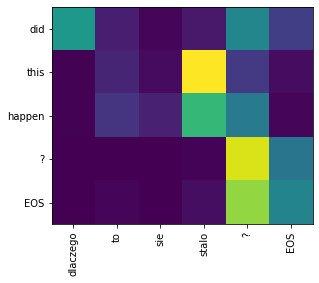

< did this happen ? EOS

> mysle ze bedziesz zalowac jesli sprzedasz gitare ojca .
= i think you ll regret it if you sell your father s guitar .


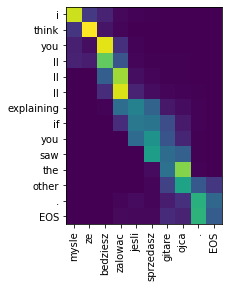

< i think you ll ll ll explaining if you saw the other . EOS

> bylem tu pierwszy .
= i was here first .


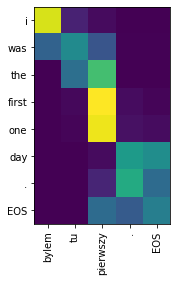

< i was the first one day . EOS

> jestes przewrazliwiony .
= you re overemotional .


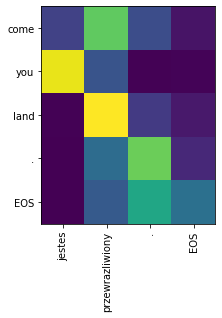

< come you land . EOS

> cale miasto bylo pozbawione pradu .
= the entire city was without electricity .


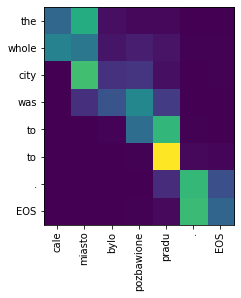

< the whole city was to to . EOS

Epoch: 50. Train loss: 0.3586810856821045
Epoch: 51. Train loss: 0.3302999037125754
Epoch: 52. Train loss: 0.34242064387552323
Epoch: 53. Train loss: 0.33951414979639505
Epoch: 54. Train loss: 0.3275917816966299
Epoch: 55. Train loss: 0.32124757542023585
Epoch: 56. Train loss: 0.3450364720017191
Epoch: 57. Train loss: 0.3144159856296721
Epoch: 58. Train loss: 0.3265791879523368
Epoch: 59. Train loss: 0.3228995926559918
Epoch: 60. Train loss: 0.2890176534179657
Epoch: 61. Train loss: 0.25255037749570514
Epoch: 62. Train loss: 0.27149584238964414
Epoch: 63. Train loss: 0.2879552694540175
Epoch: 64. Train loss: 0.2750516491276877
Epoch: 65. Train loss: 0.26590988335628357
Epoch: 66. Train loss: 0.2809640257841065
Epoch: 67. Train loss: 0.27919328472917043
Epoch: 68. Train loss: 0.3091784244964993
Epoch: 69. Train loss: 0.28395934875995393
Epoch: 70. Train loss: 0.28513347546732615
Epoch: 71. Train loss: 0.25877918929807725
Epoch: 72. Train loss: 0.2576979

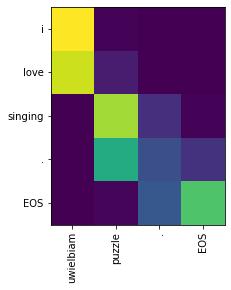

< i love singing . EOS

> wyglada na to ze rzad nie wie co robic .
= it sounds as if the government doesn t know what to do .


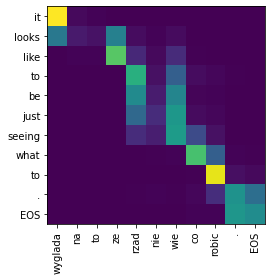

< it looks like to be just seeing what to . EOS

> bardzo potrzebuje twojej pomocy .
= i am badly in need of your help .


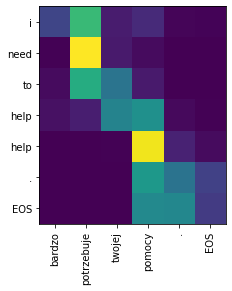

< i need to help help . EOS

> badz pomocny .
= be supportive .


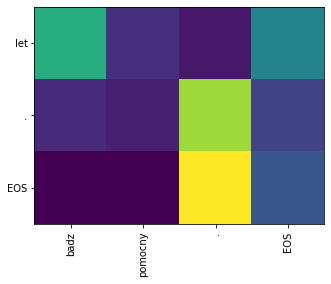

< let . EOS

> nie jestes zajety prawda ?
= you re not busy are you ?


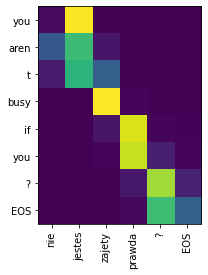

< you aren t busy if you ? EOS

Epoch: 75. Train loss: 0.2965509183113537
Epoch: 76. Train loss: 0.30298612148515763
Epoch: 77. Train loss: 0.2983297559003981
Epoch: 78. Train loss: 0.28545484762816203
Epoch: 79. Train loss: 0.30102824940094874
Epoch: 80. Train loss: 0.2941159042455847
Epoch: 81. Train loss: 0.2731519868922612
Epoch: 82. Train loss: 0.2638633268929663
Epoch: 83. Train loss: 0.26262672748121
Epoch: 84. Train loss: 0.2386903582466027
Epoch: 85. Train loss: 0.2569182279800612
Epoch: 86. Train loss: 0.288592871337656
Epoch: 87. Train loss: 0.28213866250146
Epoch: 88. Train loss: 0.2618889254591768
Epoch: 89. Train loss: 0.28335689723728197
Epoch: 90. Train loss: 0.2581216372431271
Epoch: 91. Train loss: 0.24085348022599068
Epoch: 92. Train loss: 0.2399598350009275
Epoch: 93. Train loss: 0.2256533789137999
Epoch: 94. Train loss: 0.2246735885975853
Epoch: 95. Train loss: 0.22338049178795208
Epoch: 96. Train loss: 0.258942546293376
Epoch: 97. Train loss: 0.23836433538605298
E

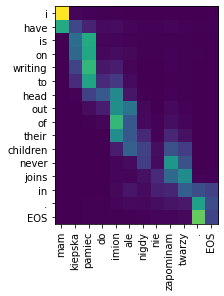

< i have is on writing to head out of their children never joins in . EOS

> dotknij tego .
= touch it .


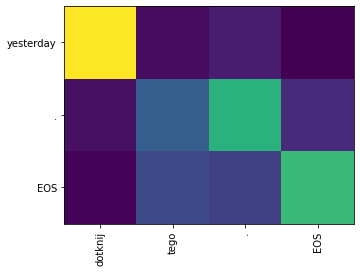

< yesterday . EOS

> czego chca ?
= what do they want ?


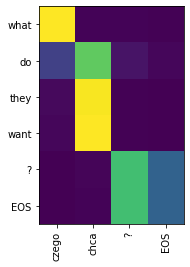

< what do they want ? EOS

> chce nowy noz .
= i want a new knife .


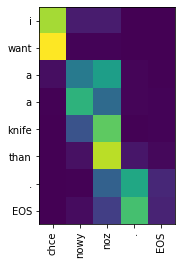

< i want a a knife than . EOS

> zalozyli klub plywacki .
= they formed a swim team .


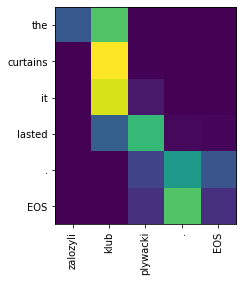

< the curtains it lasted . EOS

Epoch: 100. Train loss: 0.2404558720688025


In [ ]:
hidden_size = 128
embedding_size = 256
encoder = EncoderRNN(input_lang.n_words, embedding_size, hidden_size).to(device)
decoder = AttnDecoderRNN(output_lang.n_words, embedding_size, hidden_size).to(device)

train(encoder, decoder, lr=0.005, epochs_num=100)

# Powiązana literatura

* [Sequence to Sequence Learning with Neural Networks](https://arxiv.org/abs/1409.3215)
* [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473)

## Przydatne tutoriale

* https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
* https://github.com/bentrevett/pytorch-seq2seq
* https://github.com/gmum/AppliedDL2020/tree/master/Week%207 - materiały z kursu Applied Deep Learning prowadzonego w semestrze letnim


# Zadanie dodatkowe: Transformer (7 pkt.)

Na podstawie pracy [Attention is All You Need](https://arxiv.org/abs/1706.03762) oraz strony [The Annotated Transformer](http://nlp.seas.harvard.edu/2018/04/03/attention) zaimplementuj transformera działającego na powyższym zadaniu tłumaczenia z polskiego na angielski.

![transformer](http://nlp.seas.harvard.edu/images/the-annotated-transformer_14_0.png)